# Seq2Seq 한계
- Seq2Seq 모델은 번역(translation), 챗봇 등의 task에서 높은 성능을 보임
- 하지만 Seq2Seq 모델은 커다란 한계가 있음.
- 입력 시퀸스의 모든 정보를 하나의 고정된 크기의 벡터(컨텍스트 벡터)에 다 압축 요약하려 하다 보니 정보의 손실이 생길 수밖에 없음
- 특히 시퀸스의 길이가 길다면 정보의 손실이 더 커짐
- 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위해 어텐션(attention) 기법이 등장

# 주의 메커니즘(Attention Mechanism)
- 정보를 효과적으로 압축시키는 구조에 더해 전체 정보 가운데 어떤 정보를 참조할 것인지를 학습시키는 구조
- Seq2Seq 모델의 문제점을 개선하기 위해 제안
- 인코더에서 필요한 정보를 디코더로 가져오는 방법
- 입력의 특정 부분에 더 집중(Attention)하여 출력을 생성하는 것
- 인간이 정보를 처리할 때 특정 부분에 집중하는 방식과 유사

## Attention 핵심 구성요소
- Query
    - 질문
    - 현재 디코더의 특정 시점에서 처리 중인 상태 값
- Key
    - 가져올 정보의 고유 식별 값
    - 인코더의 입력 데이터의 특징
- Value
    - 실제로 가져올 값
    - 인코더의 입력 데이터의 실제 정보
- Attention Score
    - Query와 Key를 이용해서 어떤 Value를 얼마만큼 가져올 것인지를 결정하는 연산


## Attention 동작 방법
- Attention(Q, K, V) = Attention Value
    - Q(Query) : 디코더의 t 시점 셀의 hidden state
    - K(Keys) : 인코더의 모든 시점 셀의 hidden state
    - V(Values) : 인코더의 모든 시점 셀의 hidden state


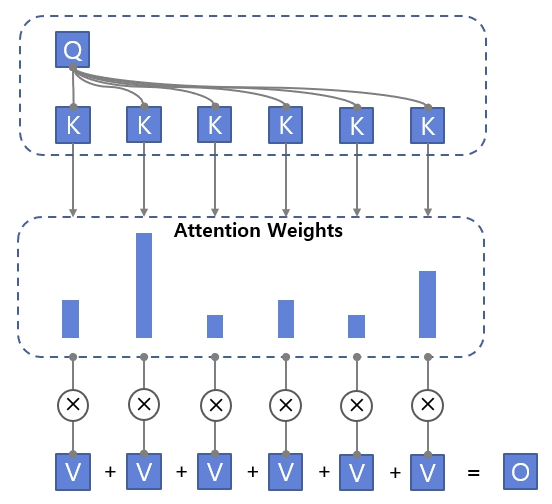

1. 어텐션 스코어(유사도)를 구함
    - 디코더의 t 시점 셀의 hidden state(Query) 와 인코더의 모든 시점 셀의 hidden state(Keys)를 내적(Dot product)하여 유사도를 구한다.

$$
e^{t}=[s_{t}^Th_{1},...,s_{t}^Th_{N}]
$$


2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구함
    - 소프트맥스를 이용하여 어텐션 스코어의 확률 분포를 구한다.

$$
α^{t} = softmax(e^{t})
$$


3. 인코더 각 시점의 어텐션 분포(가중치)와 인코더 모든 시점 셀의 hidden state(Values) 가중합하여 어텐션 값(Attention Value)을 구함
    - 인코더 모든 시점 셀의 hidden state와 어텐션 분포인 가중치들을 곱하고 합하여 어텐션 값을 구한다.

$$
a_{v}=\sum_{i=1}^{N} α_{i}^{t}h_{i}
$$


4. 어텐션 값과 디코더 t시점의 hidden state 를 연결(Concatenate)
    - 연결한 텐서를 Fully Connected Layer 에 전달하여 단어를 예측

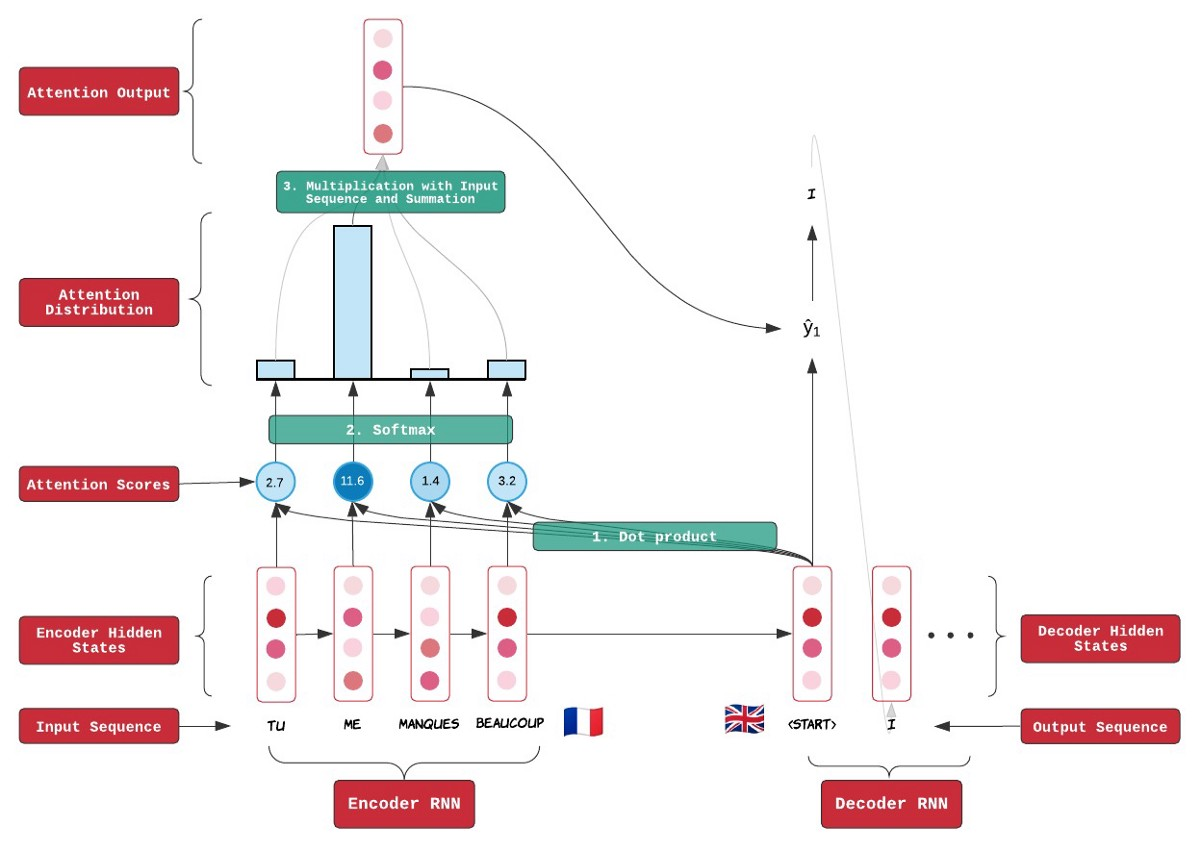

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "../data/"
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class Vocab:
    def __init__(self, tokens_list, specials = [], unk_token = None):
        self.id2token = set()
        for tokens in tokens_list:
            self.id2token.update(tokens)
        self.id2token = specials + sorted(list(self.id2token))
        self.token2id = { t:i for i, t in enumerate(self.id2token)  }
        self.unk_token = unk_token
    def __len__(self):
        return len(self.id2token)

    def __call__(self, tokens):
        return [
            self.token2id[t] if self.token2id.get(t) is not None else self.token2id[self.unk_token]
            for t in tokens
        ]

In [3]:
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")
train.shape

(5794, 2)

# 텍스트 정제

In [8]:
train["ko"] = train["ko"].str.replace("[^가-힣0-9 .,!?]", "", regex=True)

In [9]:
train["en"] = train["en"].str.replace("[^a-zA-Z0-9 .,!?]", "", regex=True)

# 한국어 토큰화

In [10]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [11]:
src_data = []
for tokens in kiwi.tokenize(train["ko"]):
    tokens = [ t.form for t in tokens ]
    src_data.append(tokens)

In [12]:
vocab_ko = Vocab(src_data, ["<pad>", "<unk>"], "<unk>")
len(vocab_ko)

3251

## 단어 번호 부여

In [13]:
src_data = [ vocab_ko(tokens) for tokens in src_data ]

# 영어 토큰화

In [14]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
from nltk.tokenize import word_tokenize

sos_token = "<sos>"
eos_token = "<eos>"
trg_data = []
for text in train["en"]:
    tokens = [sos_token] + word_tokenize(text) + [eos_token]
    trg_data.append(tokens)

In [16]:
vocab_en = Vocab(trg_data, ["<pad>", "<unk>"], "<unk>")
len(vocab_en)

3524

## 단어 번호 부여

In [17]:
trg_data = [ vocab_en(tokens) for tokens in trg_data ]

# 데이터셋 클래스

In [18]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, src, trg):
        self.src, self.trg = src, trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return {
            "src" : torch.tensor(self.src[idx]),
            "trg" : torch.tensor(self.trg[idx]),
        }

In [19]:
def collate_fn(batch_data):
    src, trg = [], []
    for data in batch_data:
        src.append(data["src"])
        trg.append(data["trg"])

    src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
    trg = torch.nn.utils.rnn.pad_sequence(trg, batch_first=True)

    return {"src": src, "trg": trg}

In [20]:
dt = TranslationDataset(src_data, trg_data)
dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=collate_fn)
batch = next(iter(dl))
batch

{'src': tensor([[2281, 2572,  889, 2238,  143, 2238, 3054, 2281,  701,    4],
         [1202, 2281, 2850,  854, 1997,  701,    4,    0,    0,    0]]),
 'trg': tensor([[  33,  531, 2553,  741, 2328, 3159, 2749, 2582,    4,   32],
         [  33,  527, 2167, 3378,  995,    4,   32,    0,    0,    0]])}

# Encoder Layer

In [29]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Embedding(vocab_size, emb_size),
            torch.nn.LSTM(emb_size, emb_size * 2, batch_first=True, bidirectional=True)
        )

    def forward(self, x): # x: src_data
        outputs, (hn, cn) = self.seq(x)

        # nlayer(2), batch, feature -> batch, nlayer(2), feature -> nalyer(1), batch, nlayer(2) * feature
        hn = hn.permute(1, 0, 2).flatten(1).unsqueeze(0)
        cn = cn.permute(1, 0, 2).flatten(1).unsqueeze(0)

        return outputs, hn, cn

In [30]:
encoder = Encoder(len(vocab_ko), 64)
outputs, hn, cn = encoder(batch["src"])

# outputs shape: batch, seq, feature
# hn, cn shape: nlayer, batch, feature
outputs.shape, hn.shape, cn.shape

(torch.Size([2, 10, 256]), torch.Size([1, 2, 256]), torch.Size([1, 2, 256]))

# Decoder Layer
- Query: 디코더의 t 시점의 히든 출력
- Keys: 인코더의 모든 시점의 히든 출력(FC layer 통과 시킴)
- Values: 인코더의 모든 시점의 히든 출력

In [62]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size, emb_size)
        self.lstm = torch.nn.LSTM(emb_size, emb_size * 4, batch_first=True)
        self.attn_key_layer = torch.nn.Linear(emb_size * 4, emb_size * 4)
        self.fc_out = torch.nn.Linear(emb_size * 8, vocab_size)

    # x에 하나의 시점이 전달됨(batch, seq(1))
    def forward(self, x, enc_outputs, hn, cn):
        x = self.emb_layer(x)
        _, (hn, cn) = self.lstm(x, (hn, cn))

        # 어텐션 시작
        attn_keys = self.attn_key_layer(enc_outputs) # batch, seq, feature
        # keys: batch, seq, feature -> seq, batch, feature -> seq, batch * feature
        attn_keys = attn_keys.permute(1, 0, 2).flatten(1)

        # nlayer(1), batch, feature -> batch * feature, 1
        attn_query = hn.view(-1, 1)

        # seq, batch * feature @ batch * feature, 1
        attn_scores = torch.matmul(attn_keys, attn_query) # seq, 1
        attn_scores = torch.nn.functional.softmax(attn_scores, dim=0)

        # attn_scores: seq, 1 -> batch, 1, seq
        # enc_outputs(value): batch, seq, feature

        # seq, 1 -> 1, 1, seq -> batch, 1, seq
        attn_scores = attn_scores.view(1, 1, -1).repeat(enc_outputs.shape[0], 1, 1)

        # batch, 1, seq @ batch, seq, feature -> batch, 1, feature
        attn_values = torch.bmm(attn_scores, enc_outputs)

        x = torch.cat([hn[-1], attn_values[:, -1]], dim=1)
        pred = self.fc_out(x)
        return pred, hn, cn

In [63]:
trg = batch["trg"][:, :1]
trg.shape

torch.Size([2, 1])

In [65]:
decoder = Decoder(len(vocab_en), 64)
pred, hn, cn = decoder(trg, outputs, hn, cn)
pred.shape, hn.shape, cn.shape

(torch.Size([2, 3524]), torch.Size([1, 2, 256]), torch.Size([1, 2, 256]))

# Seq2Seq 모델

In [66]:
class Net(torch.nn.Module):
    def __init__(self, vocab_size_src, vocab_size_trg, emb_dim=64, device="cpu"):
        super().__init__()
        self.encoder = Encoder(vocab_size_src, emb_dim)
        self.decoder = Decoder(vocab_size_trg, emb_dim)
        self.vocab_size_trg = vocab_size_trg
        self.device = device

    def forward(self, src, trg, enc_outputs=None, hn=None, cn=None, teacher_forcing_ratio=0.5):
        if hn is None:
            enc_outputs, hn, cn = self.encoder(src)

        # 예측 확률을 담아줄 (batch, seq, 예측 확률) 형태의 텐서를 만들어 줘야 함
        batch_size, trg_len = trg.shape[0], trg.shape[1]
        prediction = torch.zeros(batch_size, trg_len, self.vocab_size_trg).to(self.device)
        dec_input = trg[:, 0].view(-1, 1) # batch, seq(1)

        for t in range(1, trg_len):
            pred, hn, cn = self.decoder(dec_input, enc_outputs, hn, cn) # pred.shape: (batch, 예측확률)
            prediction[:, t] = pred
            dec_input = pred.argmax(1).view(-1, 1) # batch(클래스 번호) -> batch, seq(1)
            if random.random() < teacher_forcing_ratio:
                dec_input = trg[:, t].view(-1, 1) # batch(클래스 번호) -> batch, seq(1)

        return prediction, enc_outputs, hn, cn

In [67]:
model = Net(len(vocab_ko), len(vocab_en))
pred, enc_outputs, hn, cn = model(batch["src"], batch["trg"])
pred.shape

torch.Size([2, 10, 3524])